In [1]:
import tensorflow as tf

In [2]:
import numpy as np 
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, AveragePooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
X, y = np.load("X.npy"), np.load("Y.npy")

In [6]:
y = np.array(to_categorical(y,2))

### Training, Validation and Testing sets

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)

In [8]:
Xtest, Xvalid, ytest, yvalid = train_test_split(Xtest,ytest, test_size = 0.5,shuffle=True)

### Transfer Larning w/ Resnet50

In [9]:
resnet50 = ResNet50(weights='imagenet',  
            input_shape=(224, 224, 3),
           include_top=False)

for layer in resnet50.layers:
    layer.trainable = False

In [10]:
resnet50.output

<tf.Tensor 'conv5_block3_out/Relu:0' shape=(None, 7, 7, 2048) dtype=float32>

In [11]:
top = Sequential()
top.add(AveragePooling2D(pool_size=(4,4), input_shape=(7,7,2048)))
top.add(Flatten())
top.add(Dense(128, activation ="relu"))
top.add(Dropout(0.3))
top.add(Dense(2, activation="sigmoid"))

In [12]:
model = Sequential()
model.add(resnet50)
model.add(top)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential (Sequential)      (None, 2)                 262530    
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
opt = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer = opt, metrics=["accuracy"])
bs = 4

In [14]:
datagen = ImageDataGenerator(rotation_range=15,fill_mode ="nearest")
train = datagen.flow(Xtrain, ytrain, batch_size = bs)

In [15]:
history = model.fit(train,
                    steps_per_epoch = len(Xtrain)//bs,
                    validation_data = (Xvalid, yvalid),
                    validation_steps = len(Xvalid)//bs,
                    epochs = 10)

Epoch 1/10
51/51 [==============================] - 19s 371ms/step - loss: 0.7600 - accuracy: 0.5124 - val_loss: 0.6551 - val_accuracy: 0.6591
Epoch 2/10
51/51 [==============================] - 4s 76ms/step - loss: 0.6705 - accuracy: 0.6169 - val_loss: 0.6042 - val_accuracy: 0.8182
Epoch 3/10
51/51 [==============================] - 4s 79ms/step - loss: 0.6052 - accuracy: 0.7214 - val_loss: 0.5600 - val_accuracy: 0.8864
Epoch 4/10
51/51 [==============================] - 4s 74ms/step - loss: 0.5673 - accuracy: 0.7413 - val_loss: 0.5200 - val_accuracy: 0.9091
Epoch 5/10
51/51 [==============================] - 4s 77ms/step - loss: 0.5462 - accuracy: 0.8209 - val_loss: 0.4880 - val_accuracy: 0.8864
Epoch 6/10
51/51 [==============================] - 4s 74ms/step - loss: 0.4936 - accuracy: 0.9055 - val_loss: 0.4496 - val_accuracy: 0.9091
Epoch 7/10
51/51 [==============================] - 4s 74ms/step - loss: 0.4652 - accuracy: 0.8607 - val_loss: 0.4115 - val_accuracy: 0.9545
Epoch 8/10


In [18]:
_,eval_accuracy = model.evaluate(Xtest, ytest, batch_size=bs)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 

11/11 [==============================] - 0s 13ms/step - loss: 0.3752 - accuracy: 0.9545
Accuracy: 95.45%


### History Graph

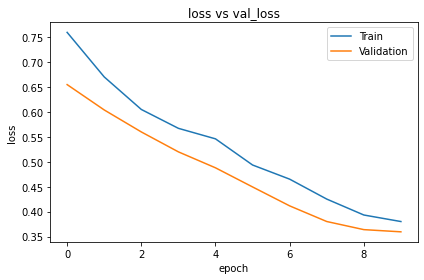

In [19]:
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('loss vs val_loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

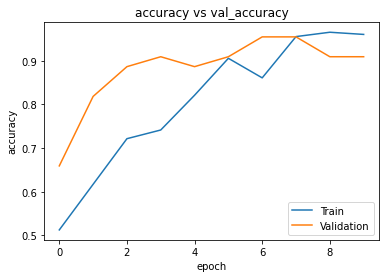

In [20]:
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('accuracy vs val_accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['Train', 'Validation'], loc='lower right')

In [ ]:
model.save("resnet.h5")
print("Saved model to disk")

## Classification report and Confusion Matrix

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as s

#### Classification report

In [22]:
y_pred = model.predict(Xtest)
names = ['covid', 'Normal']

In [23]:
print(classification_report(ytest.argmax(axis=1), y_pred.argmax(axis=1),  target_names= names))

              precision    recall  f1-score   support

       covid       1.00      0.93      0.96        27
      Normal       0.89      1.00      0.94        17

    accuracy                           0.95        44
   macro avg       0.95      0.96      0.95        44
weighted avg       0.96      0.95      0.95        44



#### Confusion Matrix

In [24]:
conf_matrix = confusion_matrix(ytest.argmax(axis=1),y_pred.argmax(axis=1))

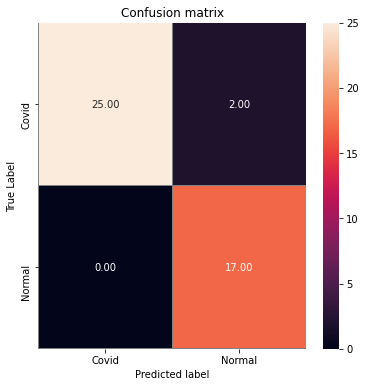

In [25]:
f,ax = plt.subplots(figsize = (6,6))
plt.title("Confusion matrix")
s.heatmap(conf_matrix,annot=True,linewidths = 0.01,
            linecolor = "gray",fmt = ".2f",ax=ax)
plt.xlabel("Predicted label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(['Covid', 'Normal']); ax.yaxis.set_ticklabels(['Covid', 'Normal']);

###  What does it mean ?

So based on all the previous plot, confusion matrix, etc, it seems that the NN is kind of able to distinguish what is a healthy person lung look likes compared to a COVID-19 infected lungs. Anyone shoud be happy with such results, but remember, we're in a medical case, we need to be able to show why does it says that this or that is "healhty" or "COVID-19". This is where GRAD-CAM comes in.

## GRAD-CAM (Class Activation Heatmap)

In [9]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing.image import load_img
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import cv2

In [10]:
import keras
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
resnet50 = load_model('resnet.h5')

We will here create a set of images for testting our GRAD-CAM

In [11]:
label = []
for i in range(len(Xtest)):
    im = Image.fromarray((Xtest[i] * 255).astype(np.uint8))
    im.save("test"+str(i)+".jpg")
    label.append(ytest[i])

The following code is inspired by Keras Grad-CAM activation visualization tutorial, here: https://keras.io/examples/vision/grad_cam/

We'll create some functions for more efficiency.

In [12]:
def model():

    inp = keras.Input(shape=(224,224,3))
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inp,
                                              input_shape=(224, 224, 3))
    base_model.trainable = False

    block5_pool = base_model.get_layer("conv5_block3_out")

    x = AveragePooling2D(pool_size=(4,4))(block5_pool.output)
    x = Flatten()(x)
    x = Dense(128, activation ="relu")(x)
    x = Dropout(0.4)(x)
    x = (Dense(2, activation="sigmoid"))(x)


    model = tf.keras.models.Model(inputs = inp, outputs = x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    # Create a graph that outputs target convolution and output
    grad_model = tf.keras.models.Model(inputs = [model.input], 
                                       outputs=[model.output, model.get_layer('conv5_block3_out').output])
    return grad_model

In [13]:
def heatmap(model,img):
    
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img)
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, (224,224))
    img = tf.reshape(img, (1, 224,224,3))
    
    with tf.GradientTape() as tape:
        predictions, conv_outputs = grad_model(img)
        tape.watch(conv_outputs)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, conv_outputs)

    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_outputs, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    return heatmap, img

In [14]:
def cam(heatmap, img):
    npimg = np.array(img[0])
    output_image = cv2.addWeighted(cv2.cvtColor(npimg.astype('uint8'), cv2.COLOR_RGB2BGR), 1.0, heatmap, 0.5, 0)
    
    return output_image

In [15]:
grad_model = model()

List of test images, for the subplot bellow

In [16]:
test = ["test"+str(i)+".jpg" for i in range(12)]

In [17]:
hmap, img = [], []

for image in test:
    out = heatmap(grad_model, image)
    hmap.append(out[0])
    img.append(out[1])

In [18]:
output_cam = [cam(i,j) for i,j in zip(hmap,img)]

In [19]:
len(output_cam)

12

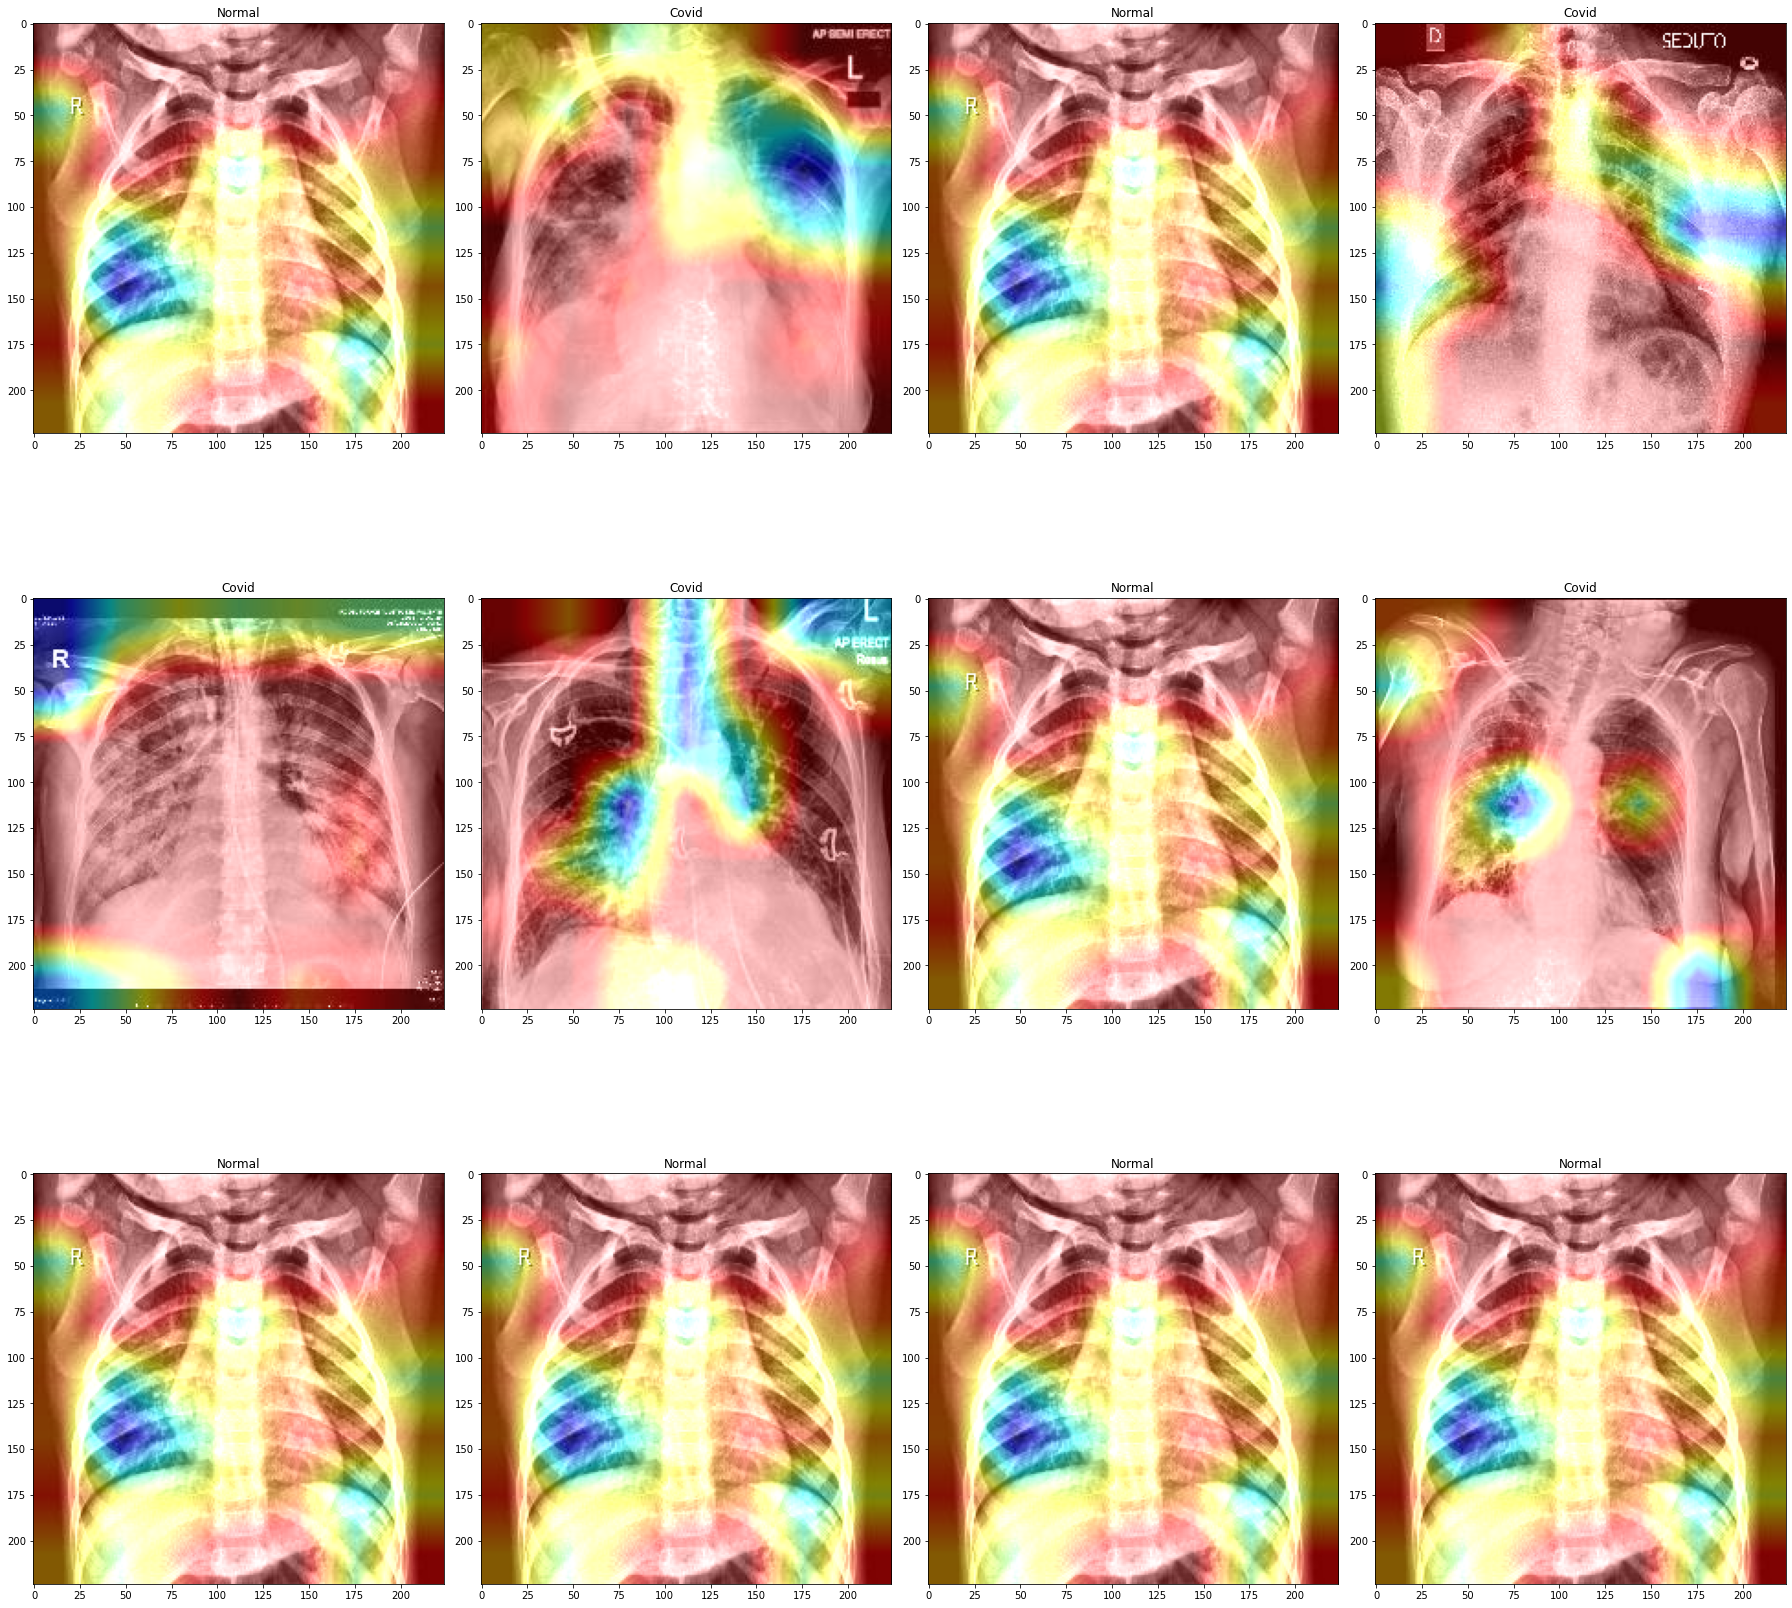

In [20]:
plt.figure(figsize=(25,25))
names = ["Covid","Normal"]
plt.gca().set_title('title')
for i in range(len(output_cam)):
    plt.subplot(3,4,i+1)
    plt.imshow(output_cam[i])
    plt.gca().set_title(str(names[round(np.argmax(label[i]))]))
    
plt.tight_layout()

### What does it say ?

GRAD-CAM is usefull because it gives us the ability to demystify the "Neural network are black boxes" saying. To put it simply, when applying a CAM we can see where the network look to make his decision.
If we look at the figure above, we can see that the network most of the time looks at the lungs to make his decision which is already a good sign that it knows what is the subject (lungs), because it happens that it can focus on something completly different and irrevelant to take a decision.
So we can see that for a "covid-19" lung, the focus is put on either the right lung or left lungs or sometimes on specific areas of the both lungs, while for "Normal" it seems to focus on the upper part of the lungs while also slighly looking at the bottom part. Of course these results are not optimal, the focus needs to be put only on the lungs whereas even if it actively looks at some part of the images it is still to scattered. A solution to this would be to give the images to a UNet network to task the lungs mask and the finaly network will be trained only on the segmented part, so the focus will only be put on the lungs and this THE ENTIRE TIME.